# Monte Carlo Simulation of the Ising Model

## Ising Model

The Ising model, named after the physicist Ernst Ising, is a mathematical model of ferromagnetism in statistical mechanics. The model consists of discrete variables that represent magnetic dipole moments of atomic "spins" that can be in one of two states (+1 or −1). The spins are arranged in a graph, usually a lattice (where the local structure repeats periodically in all directions), allowing each spin to interact with its neighbors. Neighboring spins that agree have a lower energy than those that disagree; the system tends to the lowest energy but heat disturbs this tendency, thus creating the possibility of different structural phases. The model allows the identification of phase transitions, as a simplified model of reality.

In this simulation we have a 2D lattice and like we said before, the spins only interact with its nearest neihgbours. The Hamiltonian of this system is the following:
\begin{equation}H=-J \sum_{\langle i, j\rangle} S_{i} S_{j}\end{equation}
Where $\langle i, j\rangle$ are all the pairs of the nearest neigbour for each of the elements in the lattice. $S_i$ are the spins of the electrons, either +1 or -1. <br> Ising models can be classified according to the sign of the interaction:
- $J_{i j} > 0$ ,the interaction is called *ferromagnetic*,
- $J_{i j} < 0$, the interaction is called *antiferromagnetic*
- $J_{i j} = 0$ , the spins are *noninteracting*.

In this model we consider a ferromagnetic material.

## Monte Carlo Flow Diagram

The steps are more or less straightforward and it can be divided into 3 steps:
1. Setting Up 
2. Markov Chain (the random part)
3. Calculate the Averages

Let us start then, first up we import the modules we need.

In [98]:
import numpy as np
import random
from random import choice
import time
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

The next one makes our python code run at C+ or Fortran like speeds, a really usefull module!

In [3]:
from numba import jit

### Setting Up
Define a lattice of $N$ sites $i$ , each occupied by a spin 
$S_{ij}=\pm1$, with nearest neighbours interactions. <br>

In [5]:
@jit(nopython=True)
def create_lattice(size):
    return np.ones((size,size))

In [6]:
A=create_lattice(2)
A

array([[1., 1.],
       [1., 1.]])

One might wonder why we make all the lattice spins equal to one. When the temperature is low then the lowest energy configuration is when the spins are all lined up in the same direction. If the spins would be all randomly alligned in both directions then we would have do a couple of iterations before the system is in its stable configuration before we can take accurate averages. Only at higher temperatures a random state provides the best starting configuration. 
<br>
Define the interaction $J=1$  and the Hamiltionian $H$ . 
Use “periodic boundary conditions”.

In [8]:
@jit(nopython=True)
def Hamiltonian(lattice):
    
    N=len(lattice)
    
    H=np.zeros((N,N))
    
    # next up, we only count the nearest neighours.
    
    for index, el in np.ndenumerate(lattice):
        
        i=index[0]
        j=index[1]
    
        left   = lattice[(i, j - 1)]
        right  = lattice[(i, (j + 1) % N)]
        up    = lattice[(i - 1, j)]
        down = lattice[((i + 1) % N, j)]
        
        nn=el*(up+down+left+right)
        
        H[i,j]=nn
        
    -1/2*(np.sum(H))

    return -1/2*(np.sum(H))

In [9]:
Hamiltonian(A)

-8.0

### Markov Chain

We need a random 'flipper'. This function will at random choose a index and flip the spin of this element.

In [24]:
@jit(nopython=True)
def flip_spin(lattice):
    U=np.copy(lattice)
    N=len(lattice[0,:])
    idx = (np.random.randint(N),np.random.randint(N))
    U[idx]*=-1
    return U,idx

Then we look if the energy of the system has become lower or higher but. Instead of calculating the energy of the whole matrix to see what is the energy difference. We can instead use the next trick since we only look at nearest neighbour interaction. This will save A LOT of computational time.

$$\Delta E=E_f-E_i= -2S_{i j} \cdot (S_{i+1 ,j}+ S_{i-1 ,j}+ S_{i ,j+1}+ S_{i, j-1} )$$

In [13]:
@jit(nopython=True)
def dE(lattice, index):
    N=len(lattice)
    i=index[0]
    j=index[1]
    
    
    left   = lattice[(i, j - 1)]
    right  = lattice[(i, (j + 1) % N)]
    up    = lattice[(i - 1, j)]
    down = lattice[((i + 1) % N, j)]
    
    return -2*lattice[index]*(up+down+right+left)

In [14]:
dE(A,(0,0))

-8.0

Calculate the Boltzmann energy: $r=e^{  \frac{-\Delta E}{k_B T}}$  , $k_B=1$.

In [10]:
@jit(nopython=True)
def r2(DE, T):
    return np.exp(-(DE)/(Kb*T))

In [11]:
Kb=1#8.6*10**(-5) #eV*K-1
@jit(nopython=True)
def r(Ei, Ef, T):
    return np.exp(-(Ef-Ei)/(Kb*T))

Later in the Flow Diagram we compare this energy to a random numder $0<z<1$ and if $r>z$ we accept the change otherwise we keep the origingal structure. We calculate however the averages wether or not the spin flip has been accepted or not.

### Averages

The calculations of the averages are pretty straightforward, one important thing to notice is that we always make us of an average quantity per spin. The averages are done over a sample of iterations and then there is another average over the spin.
1. Energy, $E= <H>$
2. Magnetization, $M=<S>$.
3. Specific Heat, $C=(<H^2>-<H>^2)/k_B T^2$.
4. Susceptibility, $\chi=(<S^2>-<S>^2)/k_B T$

In [15]:
@jit(nopython=True)
def Magnetization(lattice):
    return abs(np.sum(lattice))

In [16]:
Magnetization(A)

4.0

In [17]:
@jit(nopython=True)
def average(lijst):
    return np.sum(lijst)/len(lijst)

In [18]:
@jit(nopython=True)
def average_2(lijst):
    return np.sum(np.power(lijst,2))/len(lijst)

In [19]:
@jit(nopython=True)
def average_4(lijst):
    return np.sum(np.power(lijst,4))/len(lijst)

### Markov Chain Flow Diagram

In [44]:
@jit(nopython=True)

def algoritm(lattice, n0, nmax, T):
    U=np.copy(lattice)
    N=len(lattice[:,0])
    E_initial=Hamiltonian(U)

    E_i=E_initial
    
    n=0
    i=0
    
    M=np.zeros(nmax-n0+1)
    E=np.zeros(nmax-n0+1)
    
    while n <= nmax:
        flipper=flip_spin(U)
        hypotetical_lattice=flipper[0]
        Delta_E=dE(hypotetical_lattice, flipper[1])

            
        R= r2(Delta_E, T)
        z=random.random()
 
            
        if R>z:
            U=hypotetical_lattice
            E_i+=Delta_E
                    
        
        if n >= n0:
                M[i]=Magnetization(U)
                E[i]=E_i
                i+=1
        n+=1
        
    ave_M=abs(average(M))
    ave_E=average(E)
    
    susc=(1/T)*(average_2(M)/(N**2)-ave_M**2/(N**2))
    spec_heat=(1/T**2)*(average_2(E)/(N**2)-ave_E**2/(N**2))
    
    g_l=1/2*(3-((average_4(M))/(average_2(M)**2)))
    
    return ave_M/(N**2), ave_E/(N**2), susc, spec_heat, g_l , M,E,U

Let's find the iterations needed for the thermic equilibrum of a certain temperature,

In [45]:
A=create_lattice(16)

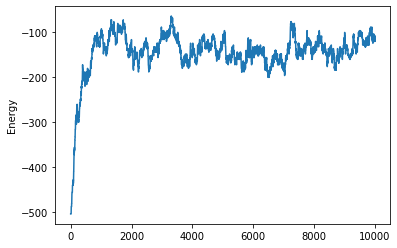

In [46]:
it=10000
x=np.arange(it)
y=algoritm(A,1,it,T=4.2)
plt.plot(x,y[-2])
plt.ylabel('Energy')
plt.show()


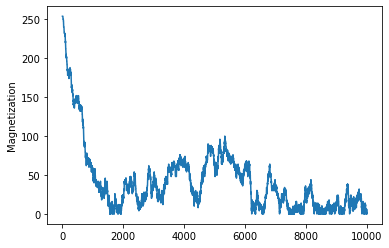

In [47]:
plt.plot(x,y[-3])
plt.ylabel('Magnetization')
plt.show()

In [48]:
%%time
A=create_lattice(32)

final=algoritm(A,10,10000,2.5)


Wall time: 15.6 ms


# Simulation

The goal of this project is to see when a phase transition occurs, therefore we need to do the above for different values of $T$. It is smart to start at $T=0$ and then increase $T$ with a small amount and use the end configuration of the last $T$. Therefore we don't have to wait before the system is in a stable configuration.  

In [49]:
@jit(nopython=True)
def calculate(Temperature, A, n0, nmax):
    U=np.copy(A)
    N=len(Temperature)
    
    M_vector=np.zeros(N)
    E_vector=np.zeros(N)
    X_vector=np.zeros(N)
    C_vector=np.zeros(N)
    Gl_vector=np.zeros(N)

    i=0
    
    for t in Temperature:
       

        alg=algoritm(U,n0,nmax,t)

        M_vector[i]=alg[0]
        E_vector[i]=alg[1]

        X_vector[i]=alg[2]
        C_vector[i]=alg[3]
        
        Gl_vector[i]=alg[4]

        

        U=alg[-1]
        
        i+=1
        
        
        
    return np.abs(M_vector), E_vector, X_vector, C_vector, Gl_vector

In [107]:
%%time

Temp=np.linspace(0.5,5,num=50)


# A=create_lattice(2)
# lattice_2=calculate(Temp, A, 100, 10000)

# A=create_lattice(4)
# lattice_4=calculate(Temp, A, 100, 10000)

A=create_lattice(8)
lattice_8=calculate(Temp, A, 10000, 100000)

A=create_lattice(16)
lattice_16=calculate(Temp, A, 10000, 1000000)

A=create_lattice(32)
lattice_32=calculate(Temp, A, 10000, 1000000)


Wall time: 1min 45s


In [108]:
Tc=2.27
id=next(x[0] for x in enumerate(Temp) if x[1] > Tc)
id

20

# Results

## Magnetization

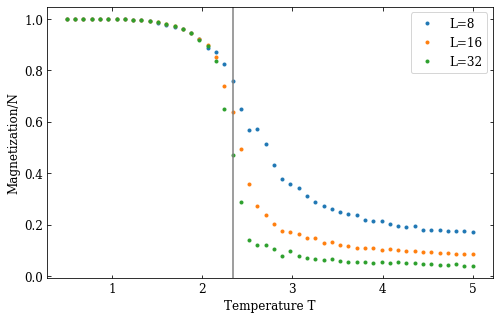

In [177]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)

# plt.plot(Temp,lattice_2[0],'.', label=('S=2'))

# plt.plot(Temp,lattice_4[0],'.', label=('S=4'))
plt.plot(Temp,lattice_8[0],'.', label=('L=8'))

plt.plot(Temp,lattice_16[0],'.', label=('L=16'))
plt.plot(Temp,lattice_32[0],'.', label=('L=32'))

plt.axvline(x=Temp[id],color='grey')

plt.legend()
plt.xlabel('Temperature T')
plt.ylabel('Magnetization/N')
plt.legend()
plt.show()

When the lattice size is higher, the curve is steeper. This is a clue for a phase transition. As lattice in 'the real world' go to infinity, we expect there to be a step like function. Notice that this is the absolute value of the magnetization as the there is no difference if we flip all the spins. The magnetization goes to zero for higher temperatures which is in agreement with the theory, the spins are then randomly pointed up-and downwards.

## Energy

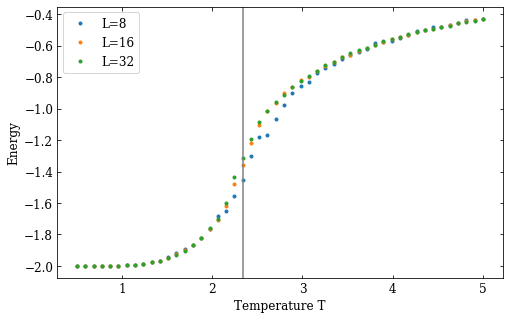

In [176]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)
# plt.plot(Temp,lattice_2[1],'.', label=('S=2'))
# plt.plot(Temp,lattice_4[1],'.', label=('S=4'))
plt.plot(Temp,lattice_8[1],'.', label=('L=8'))
plt.plot(Temp,lattice_16[1],'.', label=('L=16'))
plt.plot(Temp,lattice_32[1],'.', label=('L=32'))

plt.axvline(x=Temp[id],color='grey')

plt.xlabel('Temperature T')
plt.ylabel('Energy')
plt.legend()
plt.show()

The curve goes slightly steeper for higher values of $L$. The energy is also higher than it is for lower temperatures, wich agrees with the theory that randomly aligned spins have more energy than lower ones.

## Susceptibility

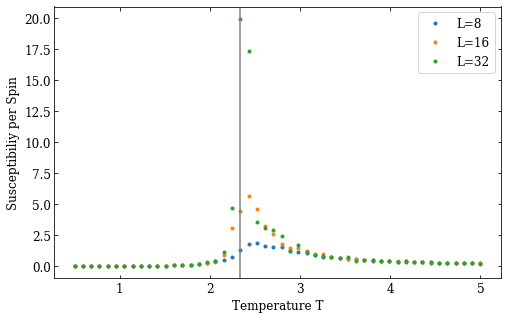

In [175]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)
# plt.plot(Temp,lattice_2[2],'.', label=('S=2'))
# plt.plot(Temp,lattice_4[2],'.', label=('S=4'))
plt.plot(Temp,lattice_8[2],'.', label=('L=8'))

plt.plot(Temp,lattice_16[2],'.', label=('L=16'))
plt.plot(Temp,lattice_32[2],'.', label=('L=32'))

plt.axvline(x=Temp[id],color='grey')

plt.xlabel('Temperature T')
plt.ylabel('Susceptibiliy per Spin')
plt.legend()
plt.show()

Here we clearly see finite size effects. For a second order phase transition we expect a divergence. This divergence becomes more clear the larger the lattice size. However due to the 'finite-ness' of the cluster, there will never be an actual divergent point. The same applies to the specific heat below.

## Specific Heat

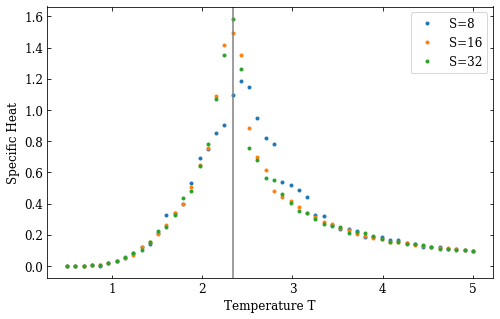

In [178]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)

# plt.plot(Temp,lattice_2[3],'.', label=('S=2'))
# plt.plot(Temp,lattice_4[3],'.', label=('S=4'))
plt.plot(Temp,lattice_8[3],'.', label=('S=8'))
plt.plot(Temp,lattice_16[3],'.', label=('S=16'))
plt.plot(Temp,lattice_32[3],'.', label=('S=32'))
plt.axvline(x=Temp[id],color='grey')
plt.xlabel('Temperature T')
plt.ylabel('Specific Heat')
plt.legend()
plt.show()

## Finite Theory

In [113]:
beta=1/8
gamma=7/3
mu=1

In [114]:
Y_8=lattice_8[0]*np.power(8,-beta/mu)
X_8=np.power(8,1/mu)*(Temp-Tc)

Y_16=lattice_16[0]*np.power(16,-beta/mu)
X_16=np.power(16,1/mu)*(Temp-Tc)

Y_32=lattice_32[0]*np.power(32,-beta/mu)
X_32=np.power(32,1/mu)*(Temp-Tc)

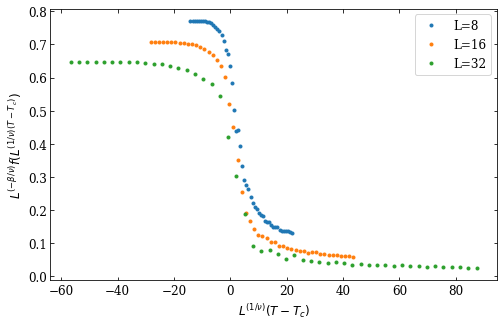

In [115]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.plot(X_8,Y_8,'.', label='L=8')
plt.plot(X_16,Y_16,'.', label='L=16')
plt.plot(X_32,Y_32,'.', label='L=32')


plt.legend()
plt.xlabel(r'$L^{(1/\nu)}(T-T_c)$')
plt.ylabel(r'$L^{(-\beta/\nu)} f(L^{(1/\nu)(T-T_c)})$')
plt.show()

In [116]:
Y_8_2=lattice_8[2]*np.power(8,beta/mu)
X_8_2=np.power(8,-gamma/mu)*(Temp-Tc)

Y_16_2=lattice_16[2]*np.power(16,beta/mu)
X_16_2=np.power(16,-gamma/mu)*(Temp-Tc)

Y_32_2=lattice_32[2]*np.power(32,beta/mu)
X_32_2=np.power(32,-gamma/mu)*(Temp-Tc)

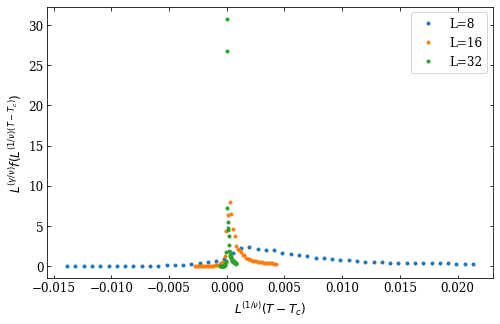

In [117]:
f = plt.figure(figsize=(8, 5))
ax = f.add_subplot(111)
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.plot(X_8_2,Y_8_2,'.',label='L=8')
plt.plot(X_16_2,Y_16_2,'.',label='L=16')
plt.plot(X_32_2,Y_32_2,'.',label='L=32')


plt.legend()
plt.xlabel(r'$L^{(1/\nu)}(T-T_c)$')
plt.ylabel(r'$L^{(\gamma/\nu)} f(L^{(1/\nu)(T-T_c)})$')
plt.show()

## Binder's razor

Using Binders Razor we can determine the critical temperature $T_c$, in this temperature the function in independant of the scale. This means that the functions for different scales must intersect. The function is defined as:
$\begin{equation}g_{L}=\frac{1}{2}\left(3-\frac{\left\langle M^{4}\right\rangle}{\left\langle M^{2}\right\rangle^{2}}\right)\end{equation}$

In [118]:
Y_8_g=lattice_8[4]
X_8_g=Temp

Y_16_g=lattice_16[4]
X_16_g=Temp

Y_32_g=lattice_32[4]
X_32_g=Temp

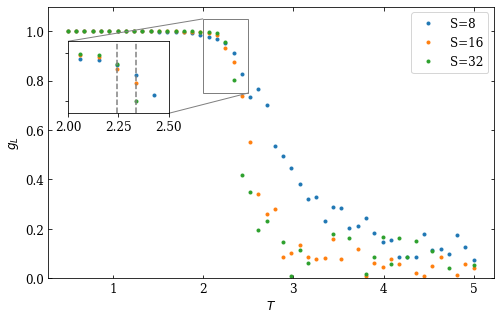

In [169]:
fig, ax = plt.subplots(figsize=(8, 5)) # create a new figure with a default 111 subplot
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)
plt.ylabel('$g_L$')
plt.xlabel('$T$')

ax.plot(X_8_g,Y_8_g,'.',label=('S=8'))
ax.plot(X_16_g,Y_16_g,'.',label=('S=16'))
ax.plot(X_32_g,Y_32_g,'.',label=('S=32'))
plt.legend()
plt.ylim(0,1.1)

axins =inset_axes(ax, 1.4,1 , loc=2,bbox_to_anchor=(0.15, 0.8),bbox_transform=ax.figure.transFigure)

axins.plot(X_8_g,Y_8_g,'.',label=('S=8'))
axins.plot(X_16_g,Y_16_g,'.',label=('S=16'))
axins.plot(X_32_g,Y_32_g,'.',label=('S=32'))
plt.axvline(x=Temp[19],ls='--',color='grey')
plt.axvline(x=Temp[20],ls='--',color='grey')
# plt.axvline(2.27,ls='--',color='red')
x1, x2, y1, y2 = 2, 2.5, 0.75,1.05 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=True)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()

On a quick glance one notices that the place where the function will overlap will be somewhere in between the two dashed lines.

In [141]:
Temp[19], Temp[20]

(2.2448979591836737, 2.336734693877551)

In [149]:
average(np.array([Temp[19], Temp[20]]))

2.2908163265306123

The (roughly) calculated intersection, the gray line, is when $T_c=2.29$. This comes fairly accurate to the exact solution of $T_c=2.269$.

Actually if we take a closer look we expect the intersection more to be at 2.269, this is the red line in the following graph.

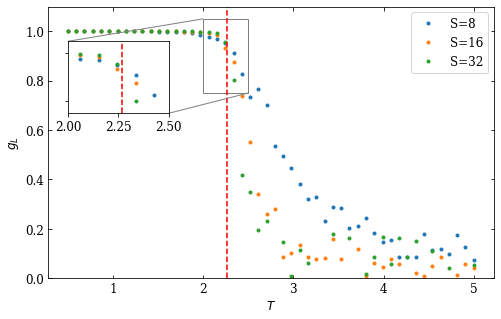

In [163]:
fig, ax = plt.subplots(figsize=(8, 5)) # create a new figure with a default 111 subplot
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
ax.tick_params(axis="both", direction="in", top=True, right=True)
plt.ylabel('$g_L$')
plt.xlabel('$T$')

ax.plot(X_8_g,Y_8_g,'.',label=('S=8'))
ax.plot(X_16_g,Y_16_g,'.',label=('S=16'))
ax.plot(X_32_g,Y_32_g,'.',label=('S=32'))
plt.axvline(2.27,ls='--',color='red')
plt.legend()
plt.ylim(0,1.1)

axins =inset_axes(ax, 1.4,1 , loc=2,bbox_to_anchor=(0.15, 0.8),bbox_transform=ax.figure.transFigure)

axins.plot(X_8_g,Y_8_g,'.',label=('S=8'))
axins.plot(X_16_g,Y_16_g,'.',label=('S=16'))
axins.plot(X_32_g,Y_32_g,'.',label=('S=32'))
# plt.axvline(x=Temp[19],ls='--',color='grey')
# plt.axvline(x=Temp[20],ls='--',color='grey')
plt.axvline(2.27,ls='--',color='red')
x1, x2, y1, y2 = 2, 2.5, 0.75,1.05 # specify the limits
axins.set_xlim(x1, x2) # apply the x-limits
axins.set_ylim(y1, y2) # apply the y-limits
plt.yticks(visible=False)
plt.xticks(visible=True)

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")


plt.show()